<input type="checkbox"> Split the original dataset into train and test sets.<br>
<input type="checkbox"> Perform EDA using the train set.<br>
<input type="checkbox"> Pre-process features.<br>
<input type="checkbox"> Split the train set into a smaller train set and a validation set.<br>
<input type="checkbox"> Perform any sampling processing (e.g., over-sampling, under-sampling) on the new train set only.<br>
<input type="checkbox"> Test a few models using the new train set and validation set, and choose the best one. Use GridSearchCV for hyperparameter tuning during this step.<br>
<input type="checkbox"> Perform cross-validation on the chosen model (with the best hyperparameters found in step 6) to estimate the general performance on unseen data.<br>
<input type="checkbox"> Perform error analysis and, if necessary, iterate on the features and model.<br>
<input type="checkbox"> Make other evaluations of the model, such as learning curves, and modify the parameters if necessary.<br>
<input type="checkbox"> Train the model with the best hyperparameters on the entire train set (excluding the test set), and apply any necessary transformations to the test set using a Pipeline.<br>
<input type="checkbox"> Test the model on the unseen test data and evaluate its performance.<br>

In [1]:
# import configurations saved from the EDA project
from configurations import *

In [2]:
# import the necessary libraries
from sklearn import preprocessing
import math
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, classification_report, recall_score, precision_score, confusion_matrix

from imblearn.over_sampling import SMOTE

#### Feature Pre-Processing

- nominal features
    - menopause
    - node_caps
    - breast
    - breast_quad
    - irrad
    - class (*target feature*)
- ordinal features
    - age
    - tumour_size
    - inv_nodes
- numerical feature
    - deg_malig

In [3]:
columns_to_keep = ['inv_nodes', 'node_caps', 'irrad', 'breast_quad', 'deg_malig', 'tumour_size']
X_train = X_train[columns_to_keep]

In [4]:
# Encode nominal features using one-hot encoding with drop_first=True
X_train_nominal = pd.get_dummies(X_train[['node_caps','breast_quad', 'irrad']], drop_first=True)

In [5]:
# Perform label encoding for ordinal features
label_encoder = preprocessing.LabelEncoder()
X_train_ordinal = X_train[['inv_nodes', 'tumour_size']].copy()  
for col in X_train_ordinal.columns:
    X_train_ordinal.loc[:, col] = label_encoder.fit_transform(X_train_ordinal[col])

In [6]:
X_train_numerical = X_train[['deg_malig']]

In [7]:
X_train_encoded = pd.concat([X_train_nominal, X_train_ordinal, X_train_numerical], axis=1)

In [8]:
X_train_encoded.head()

,node_caps_yes,breast_quad_left_low,breast_quad_left_up,breast_quad_right_low,breast_quad_right_up,irrad_yes,inv_nodes,tumour_size,deg_malig
215,0,0,1,0,0,0,0,3,2
41,0,1,0,0,0,0,0,4,2
24,0,0,1,0,0,0,0,6,2
161,1,1,0,0,0,0,4,5,2
144,1,0,0,0,0,0,5,8,3


In [9]:
y_train_encoded = y_train.replace(['no-recurrence-events', 'recurrence-events'], [0,1])

In [10]:
# create a validation set to train and evaluate the model
X_train_eval, X_eval, y_train_eval, y_eval = train_test_split(X_train_encoded, y_train_encoded, test_size=0.2, stratify=y_train_encoded, random_state=42)

In [11]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_eval, y_train_eval)

In [12]:
rfc_parameters = {
    'n_estimators': [50, 200, 300, 500],
    'max_depth': [3, 8, 15],
    'min_samples_split': [2, 5, 10, 20]
}

knn_parameters = {
    'n_neighbors': [5, 7],
    'weights': ['uniform', 'distance'],
}

lr_parameters = {
    'penalty': ['l2', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

dtc_parameters = {
    'max_depth': [None, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

svc_parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

In [13]:
def best_param(model, X_train, y_train, parameters):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(f1_score)
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=cv, scoring=scorer, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    model.set_params(**best_params)
    return model


def pred(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return model, report


In [14]:
#voting_clf = VotingClassifier(estimators=[('rfc', RandomForestClassifier()), ('knn', KNeighborsClassifier(n_neighbors=5)), ('lr', LogisticRegression())], voting='soft')
models = [RandomForestClassifier(), LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(), SVC()]

In [15]:
dfs = []

model_param_list = [
    (RandomForestClassifier(), rfc_parameters),
    (KNeighborsClassifier(), knn_parameters),
    (LogisticRegression(), lr_parameters),
    (DecisionTreeClassifier(), dtc_parameters),
    (SVC(), svc_parameters)
    ]


for model, model_parameters in zip(models, [rfc_parameters, lr_parameters, dtc_parameters, knn_parameters, svc_parameters]): 
    model_best = best_param(model, X_train_resampled, y_train_resampled, model_parameters)
    if 'Random' in str(model_best):
        random_model_best = model_best
    elif 'Logistic' in str(model_best):
        logistic_model_best = model_best
    elif 'Decision' in str(model_best):
        decision_model_best = model_best
    elif 'KN' in str(model_best):
        kn_model_best = model_best
    else:
        svc_model_best = model_best
    _, report1 = pred(model_best, X_train_resampled, y_train_resampled, X_eval, y_eval)



    df = pd.DataFrame({
        'processing': ['Combination Sampling'],
        'weighted avg_precision': [report1['weighted avg']['precision']],
        'weighted avg_recall': [report1['weighted avg']['recall']],
        'weighted avg_f1-score': [report1['weighted avg']['f1-score']],
        'precision_0': [report1['0']['precision']],
        'precision_1': [report1['1']['precision']],
        'recall_0': [report1['0']['recall']],
        'recall_1': [report1['1']['recall']],
        'f1-score_0': [report1['0']['f1-score']],
        'f1-score_1': [report1['1']['f1-score']],
        'support_0': [report1['0']['support']],
        'support_1': [report1['1']['support']]
    })

    df = df.set_index('processing')
    dfs.append(df)





# Concatenate all DataFrames
result = pd.concat(dfs, keys=[str(i) for i in range(len(dfs))])
result = result.round(2)

new_labels = {'0': 'RandomForestClassifier()', '1': 'LogisticRegression()', '2': 'DecisionTreeClassifier()', '3': 'KNeighborsClassifier()', '4': 'SVC()'}

# Rename the index labels using the dictionary
result = result.rename(index=new_labels)



format_dict = {
    'weighted avg_precision': '{:.2f}',
    'weighted avg_recall': '{:.2f}',
    'weighted avg_f1-score': '{:.2f}',
    'precision_0': '{:.2f}',
    'precision_1': '{:.2f}',
    'recall_0': '{:.2f}',
    'recall_1': '{:.2f}',
    'f1-score_0': '{:.2f}',
    'f1-score_1': '{:.2f}',
}

for col in ['support_0', 'support_1']:
    format_dict[col] = '{}'

# Highlight the maximum value in dark green for each "weighted avg_f1-score" column across all DataFrames
max_f1 = result['weighted avg_f1-score'].max()
min_f1 = result['weighted avg_f1-score'].min()
highlighted = result.style.apply(lambda x: ['background-color: darkgreen; color: white;' if val >= max_f1 and val == x['weighted avg_f1-score'] else 'background-color: red; color: white;' if val <= min_f1 and val == x['weighted avg_f1-score'] else '' for val in x], axis=1).format(format_dict)


highlighted

,,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,precision_0,precision_1,recall_0,recall_1,f1-score_0,f1-score_1,support_0,support_1
,processing,,,,,,,,,,,
RandomForestClassifier(),Combination Sampling,0.72,0.72,0.72,0.81,0.53,0.78,0.57,0.79,0.55,32,14
LogisticRegression(),Combination Sampling,0.65,0.63,0.64,0.76,0.41,0.69,0.50,0.72,0.45,32,14
DecisionTreeClassifier(),Combination Sampling,0.71,0.63,0.65,0.83,0.43,0.59,0.71,0.69,0.54,32,14
KNeighborsClassifier(),Combination Sampling,0.76,0.76,0.76,0.82,0.62,0.84,0.57,0.83,0.59,32,14
SVC(),Combination Sampling,0.68,0.67,0.68,0.77,0.47,0.75,0.50,0.76,0.48,32,14


In [16]:
kn_model_best

KNeighborsClassifier(weights='distance')

In [17]:
# performing resampling
kn_model_best.fit(X_train_resampled, y_train_resampled)
y_pred = kn_model_best.predict(X_eval)
report = classification_report(y_eval, y_pred)
y_score = kn_model_best.predict_proba(X_eval)[:, 1]
print(report)

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        32
           1       0.62      0.57      0.59        14

    accuracy                           0.76        46
   macro avg       0.72      0.71      0.71        46
weighted avg       0.76      0.76      0.76        46



In [18]:
cv_scores = cross_val_score(kn_model_best, X_train_resampled, y_train_resampled, cv=5)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", mean_cv_score)
print("Standard deviation of cross-validation score:", std_cv_score)

Cross-validation scores: [0.71153846 0.60784314 0.7254902  0.76470588 0.74509804]
Mean cross-validation score: 0.7109351432880844
Standard deviation of cross-validation score: 0.05458675865139425


In [19]:
# confusion matrix
cm = confusion_matrix(y_eval, y_pred)
print(cm)

[[27  5]
 [ 6  8]]


TN = 27: The model correctly predicted 27 instances as the negative class (0).<br>
FP = 5: The model incorrectly predicted 5 instances as the positive class (1).<br>
FN = 6: The model incorrectly predicted 6 instances as the negative class (0).<br>
TP = 8: The model correctly predicted 8 instances as the positive class (1).<br>

In [20]:
errors = X_eval[y_eval != y_pred]
error_labels = y_eval[y_eval != y_pred]
error_predictions = y_pred[y_eval != y_pred]

errors_with_labels = errors.assign(true_label=error_labels, predicted_label=error_predictions)
display(errors_with_labels)

,node_caps_yes,breast_quad_left_low,breast_quad_left_up,breast_quad_right_low,breast_quad_right_up,irrad_yes,inv_nodes,tumour_size,deg_malig,true_label,predicted_label
203,0,1,0,0,0,0,0,6,2,1,0
90,0,0,0,0,0,0,0,0,2,0,1
237,0,1,0,0,0,0,0,4,2,1,0
249,1,1,0,0,0,0,4,3,2,1,0
272,1,0,1,0,0,0,0,2,3,1,0
175,0,0,0,0,1,1,0,5,2,0,1
150,1,0,1,0,0,0,2,4,3,0,1
132,0,0,1,0,0,0,5,5,2,0,1
190,0,0,0,1,0,1,1,2,3,0,1
209,0,0,1,0,0,0,0,6,1,1,0


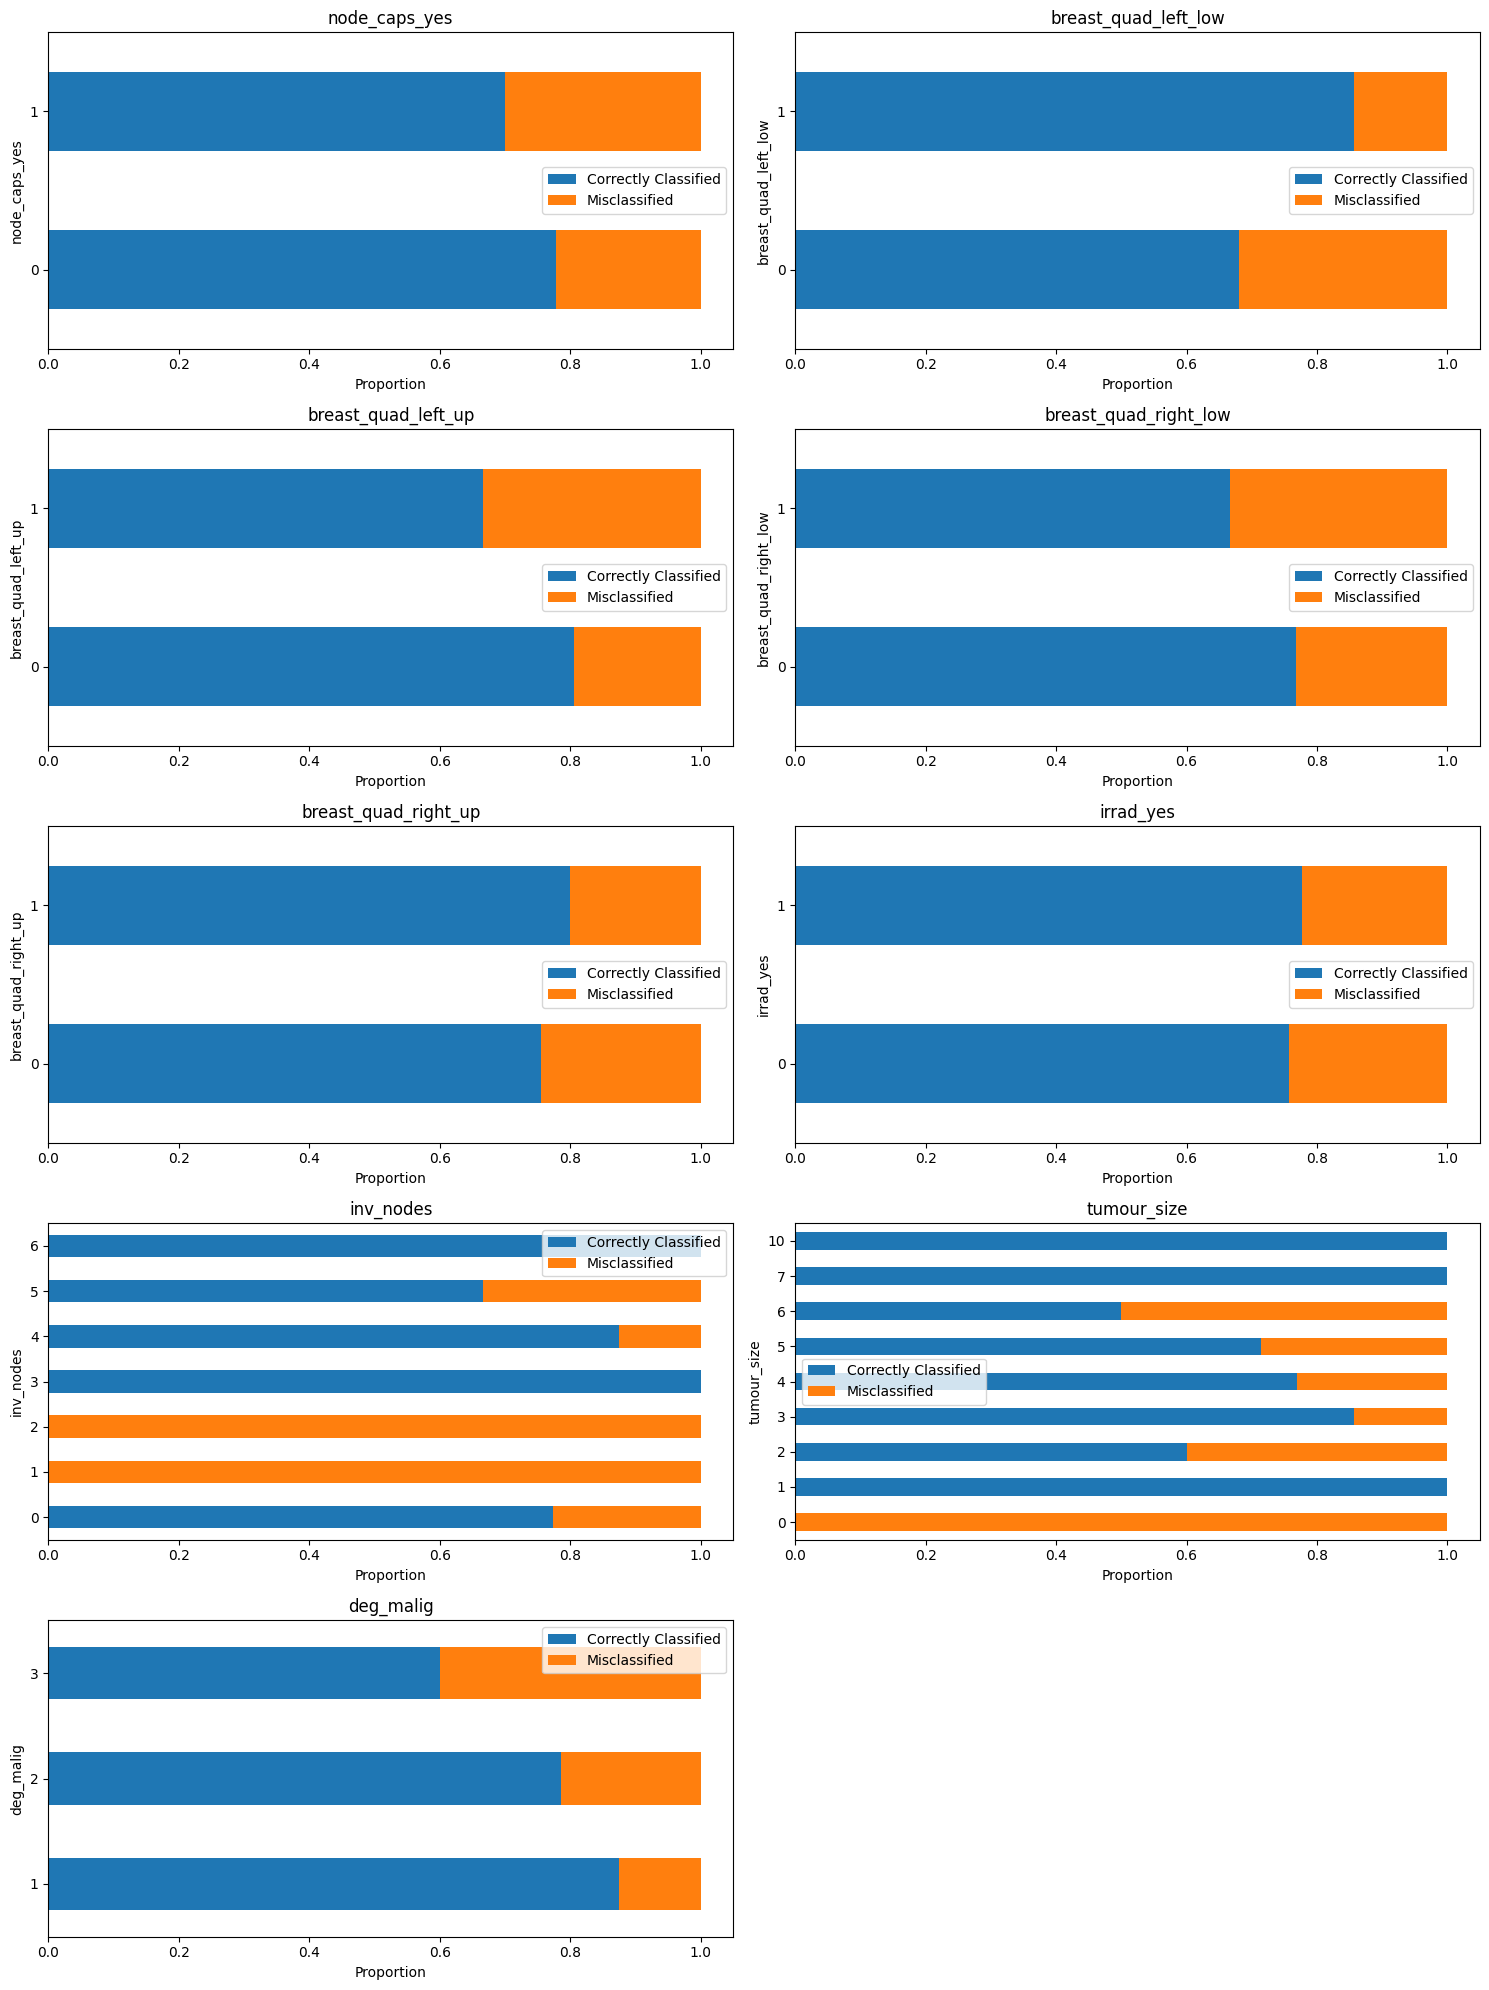

In [21]:
features = ['node_caps_yes', 'breast_quad_left_low', 'breast_quad_left_up',
            'breast_quad_right_low', 'breast_quad_right_up', 'irrad_yes',
            'inv_nodes', 'tumour_size', 'deg_malig']

# Calculate the number of rows and columns for the subplots
n_features = len(features)
ncols = 2
nrows = math.ceil(n_features / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))

for index, feature in enumerate(features):
    row, col = divmod(index, ncols)
    
    # Calculate the misclassification rate for each feature value
    misclassification_counts = errors_with_labels[feature].value_counts()
    overall_counts = X_eval[feature].value_counts()
    misclassification_rate = misclassification_counts / overall_counts

    # Calculate the classification rate for each feature value
    classification_counts = X_eval[y_eval == y_pred][feature].value_counts()
    classification_rate = classification_counts / overall_counts

    # Create a stacked bar chart
    rate_df = pd.DataFrame({'Correctly Classified': classification_rate, 'Misclassified': misclassification_rate}).fillna(0)
    rate_df.plot(kind='barh', stacked=True, ax=axes[row, col])
    axes[row, col].set_xlabel('Proportion')
    axes[row, col].set_ylabel(feature)
    axes[row, col].set_title(f'{feature}')
    axes[row, col].legend()


# Remove any unused subplots
for i in range(index+1, nrows*ncols):
    row, col = divmod(i, ncols)
    fig.delaxes(axes[row, col])

fig.tight_layout()
plt.show()


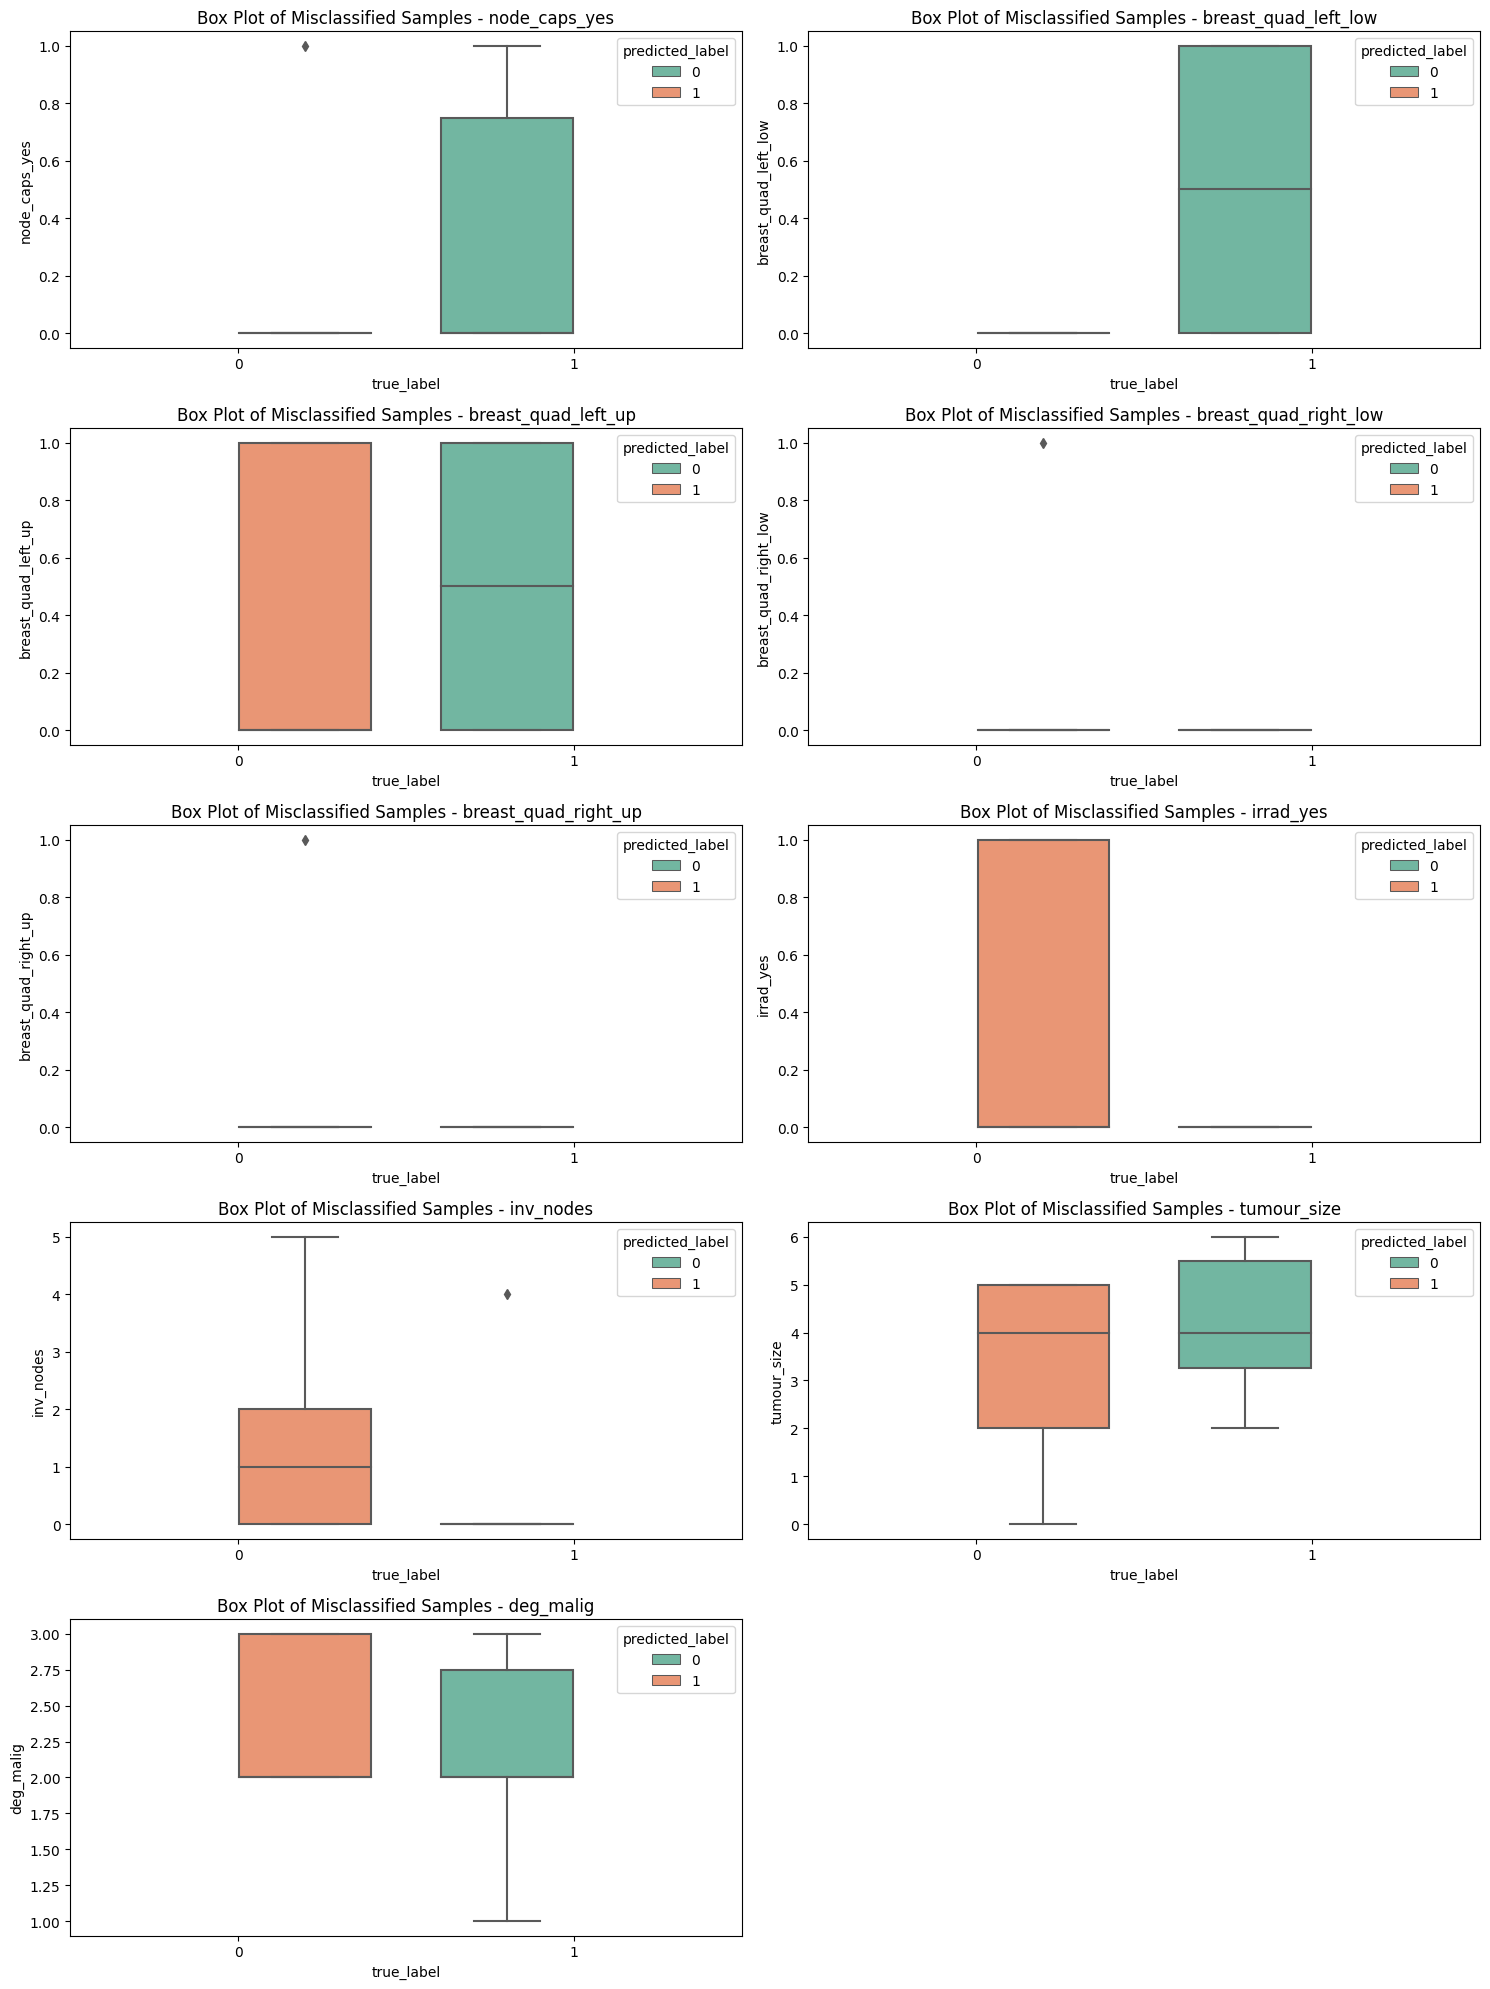

In [22]:
n_features = len(features)
ncols = 2
nrows = math.ceil(n_features / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))

for index, feature in enumerate(features):
    row, col = divmod(index, ncols)
    
    # Create a box plot for each feature
    sns.boxplot(x='true_label', y=feature, data=errors_with_labels, hue='predicted_label', palette='Set2', ax=axes[row, col])
    axes[row, col].set_title(f'Box Plot of Misclassified Samples - {feature}')

# Remove any unused subplots
for i in range(index+1, nrows*ncols):
    row, col = divmod(i, ncols)
    fig.delaxes(axes[row, col])

fig.tight_layout()
plt.show()


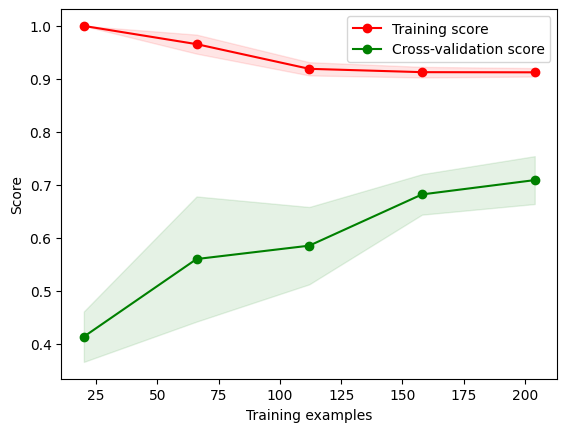

In [23]:
# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(kn_model_best, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

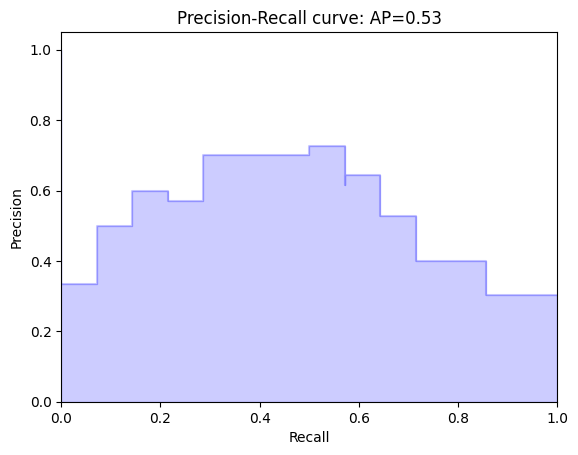

In [24]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(y_eval, y_score)
average_precision = average_precision_score(y_eval, y_score)

# plot the precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

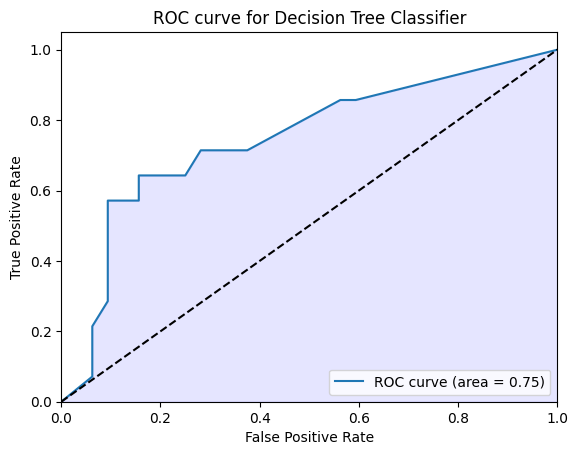

In [25]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_eval, y_score)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.fill_between(fpr, tpr, 0, color='blue', alpha=0.1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()


Exact explainer: 47it [00:20,  1.29it/s]                        


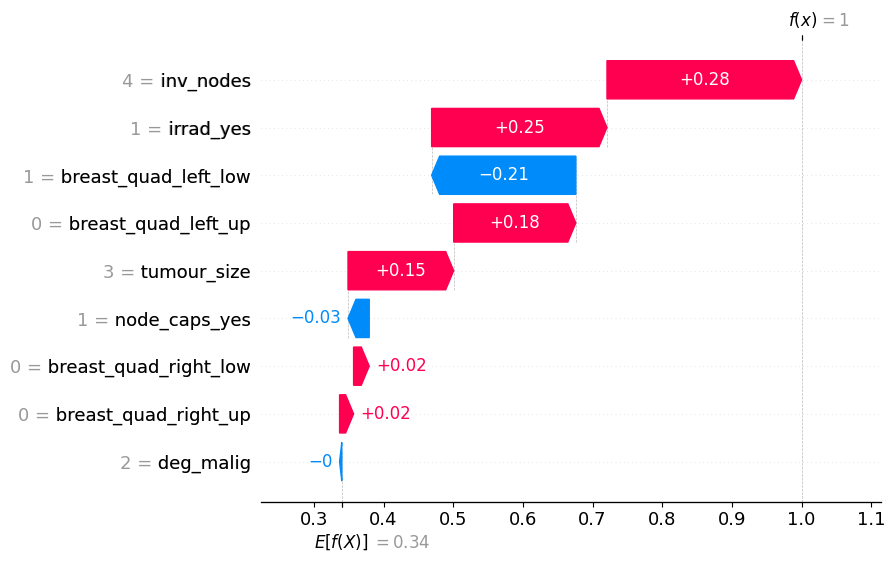

In [26]:
import shap

explainer = shap.Explainer(model.predict, X_train_resampled)
shap_values = explainer(X_eval)

# Plot the SHAP values for a single prediction
shap.plots.waterfall(shap_values[0])

##### YOU HAVE TO DO THE Test Pipeline

In [27]:
X_test = X_test[columns_to_keep]                                                                                                            

X_test_nominal = pd.get_dummies(X_test[['node_caps','breast_quad', 'irrad']], drop_first=True)


# perform label encoding for ordinal features
label_encoder = preprocessing.LabelEncoder()
X_test_ordinal = X_test[['inv_nodes', 'tumour_size']]
for col in X_test_ordinal.columns:
    X_test_ordinal[col] = label_encoder.fit_transform(X_test_ordinal[col])


X_test_numerical = X_test[['deg_malig']]                                                                                                
X_test_encoded = pd.concat([X_test_nominal, X_test_ordinal, X_test_numerical], axis=1)      


y_test_encoded = y_test.replace(['no-recurrence-events', 'recurrence-events'], [0,1])                              


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
y_pred = kn_model_best.predict(X_test_encoded)


target_names = ['0: no-recurrence-events', '1: recurrence-events']
report = classification_report(y_test_encoded, y_pred, target_names=target_names)
print('Model Performance on Unseen Data')
print(report)

Model Performance on Unseen Data
                         precision    recall  f1-score   support

0: no-recurrence-events       0.74      0.78      0.76        41
   1: recurrence-events       0.40      0.35      0.38        17

               accuracy                           0.66        58
              macro avg       0.57      0.57      0.57        58
           weighted avg       0.64      0.66      0.65        58

